In [2]:
import warnings
import pandas as pd
import arviz as az

import os, sys
dir2 = os.path.abspath('')
dir1 = os.path.dirname(dir2)
if not dir1 in sys.path: sys.path.append(dir1)
from libs.model import HGPforecaster
from libs.metrics import calculate_metrics, metrics_to_table
from libs.pre_processing import generate_groups_data
from libs.visual_analysis import visualize_fit, visualize_predict
import matplotlib.pyplot as plt
import seaborn as sns
az.style.use('arviz-darkgrid')
warnings.filterwarnings('ignore')

sns.set_palette("bright")

In [44]:
police = pd.read_excel('../data/NIBRSPublicView.Jan1-Nov30-2020.xlsx')

In [45]:
police = police.drop(['Occurrence\nHour', 'StreetName', 'Suffix', 'NIBRSDescription', 'Premise'], axis=1)
police.columns = ['Id','Date', 'Crime', 'Count', 'Beat', 'Block', 'Street', 'City', 'ZIP']
police = police.drop(['Id'], axis=1)
police = police.loc[police['City']=='HOUSTON']
police = police.drop(['City'], axis=1)

In [46]:
# I am not using Block since there are 11901 blocks in the data
police = police.groupby(['Date', 'Crime', 'Beat', 'Street', 'ZIP']).sum().reset_index().set_index('Date')

In [47]:
police['ZIP'] = police.ZIP.astype(str)

##### Using only the 500 series with larger number of counts

In [49]:
# Selecting the 500 groups combinations with higher counts

police = police.reset_index().set_index(['Crime', 'Beat', 'Street', 'ZIP']).loc[police.groupby(['Crime', 'Beat', 'Street', 'ZIP']).sum().sort_values(by=['Count'], ascending=False)[:500].index].reset_index().set_index('Date')

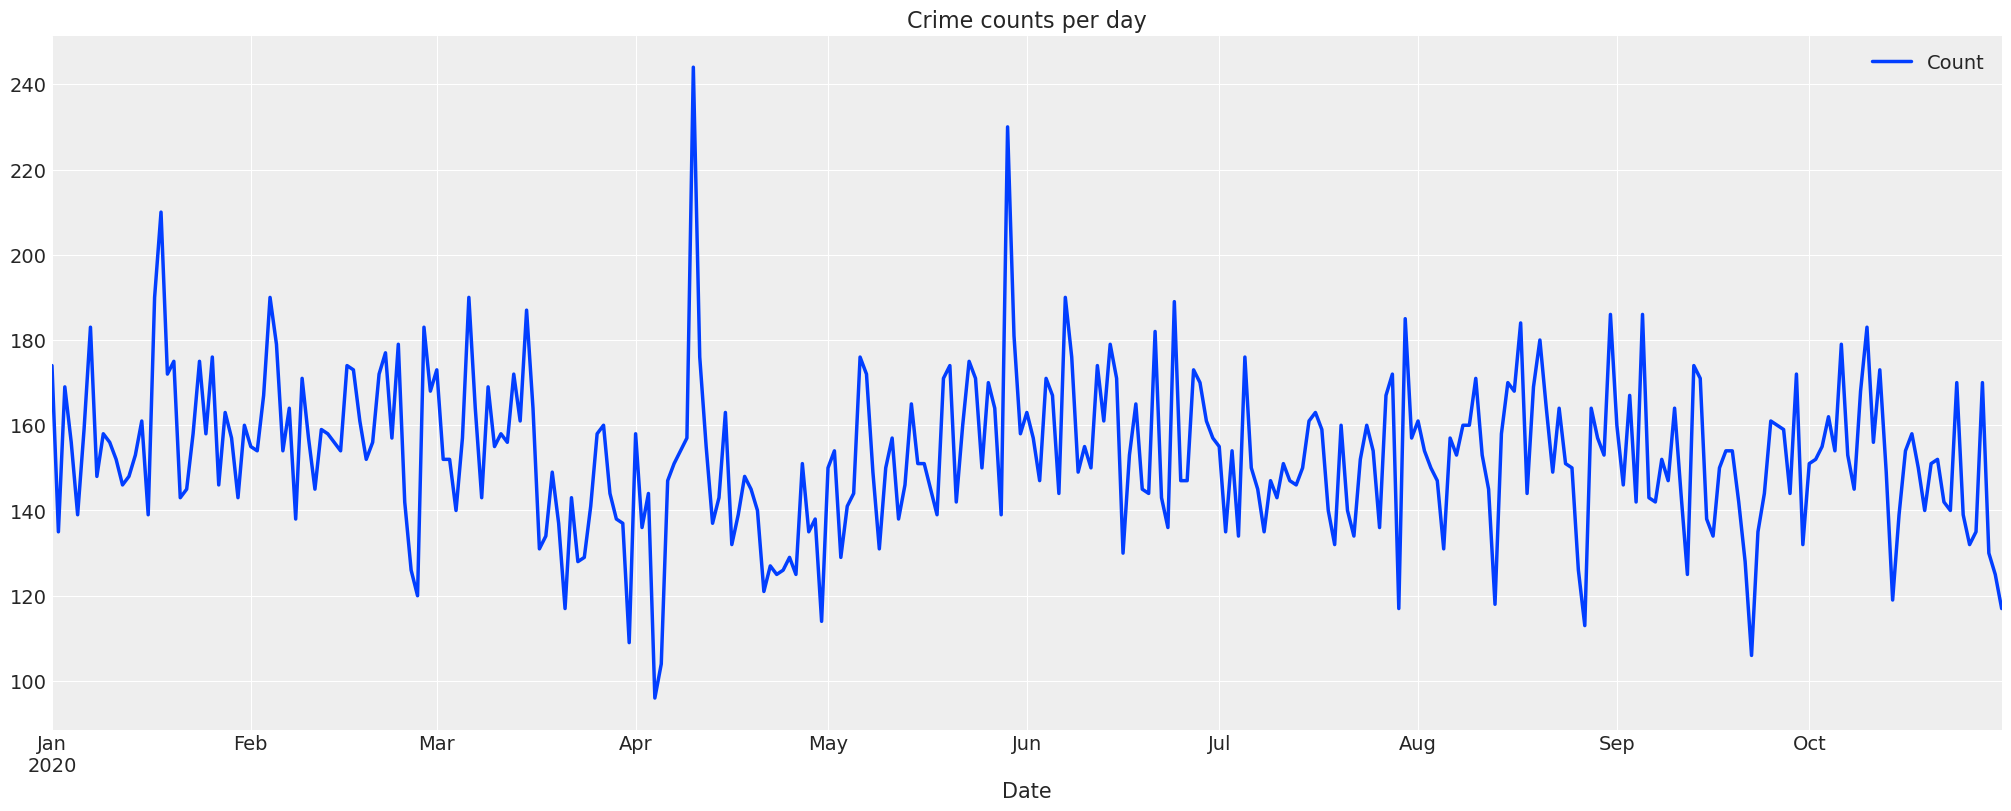

In [50]:
police.groupby(['Date']).sum().plot(figsize=(20, 8), linewidth=2.5, title='Crime counts per day');

In [51]:
print(len(police['Crime'].unique()))
print(len(police['Beat'].unique()))
print(len(police['Street'].unique()))
print(len(police['ZIP'].unique()))

15
79
9
68


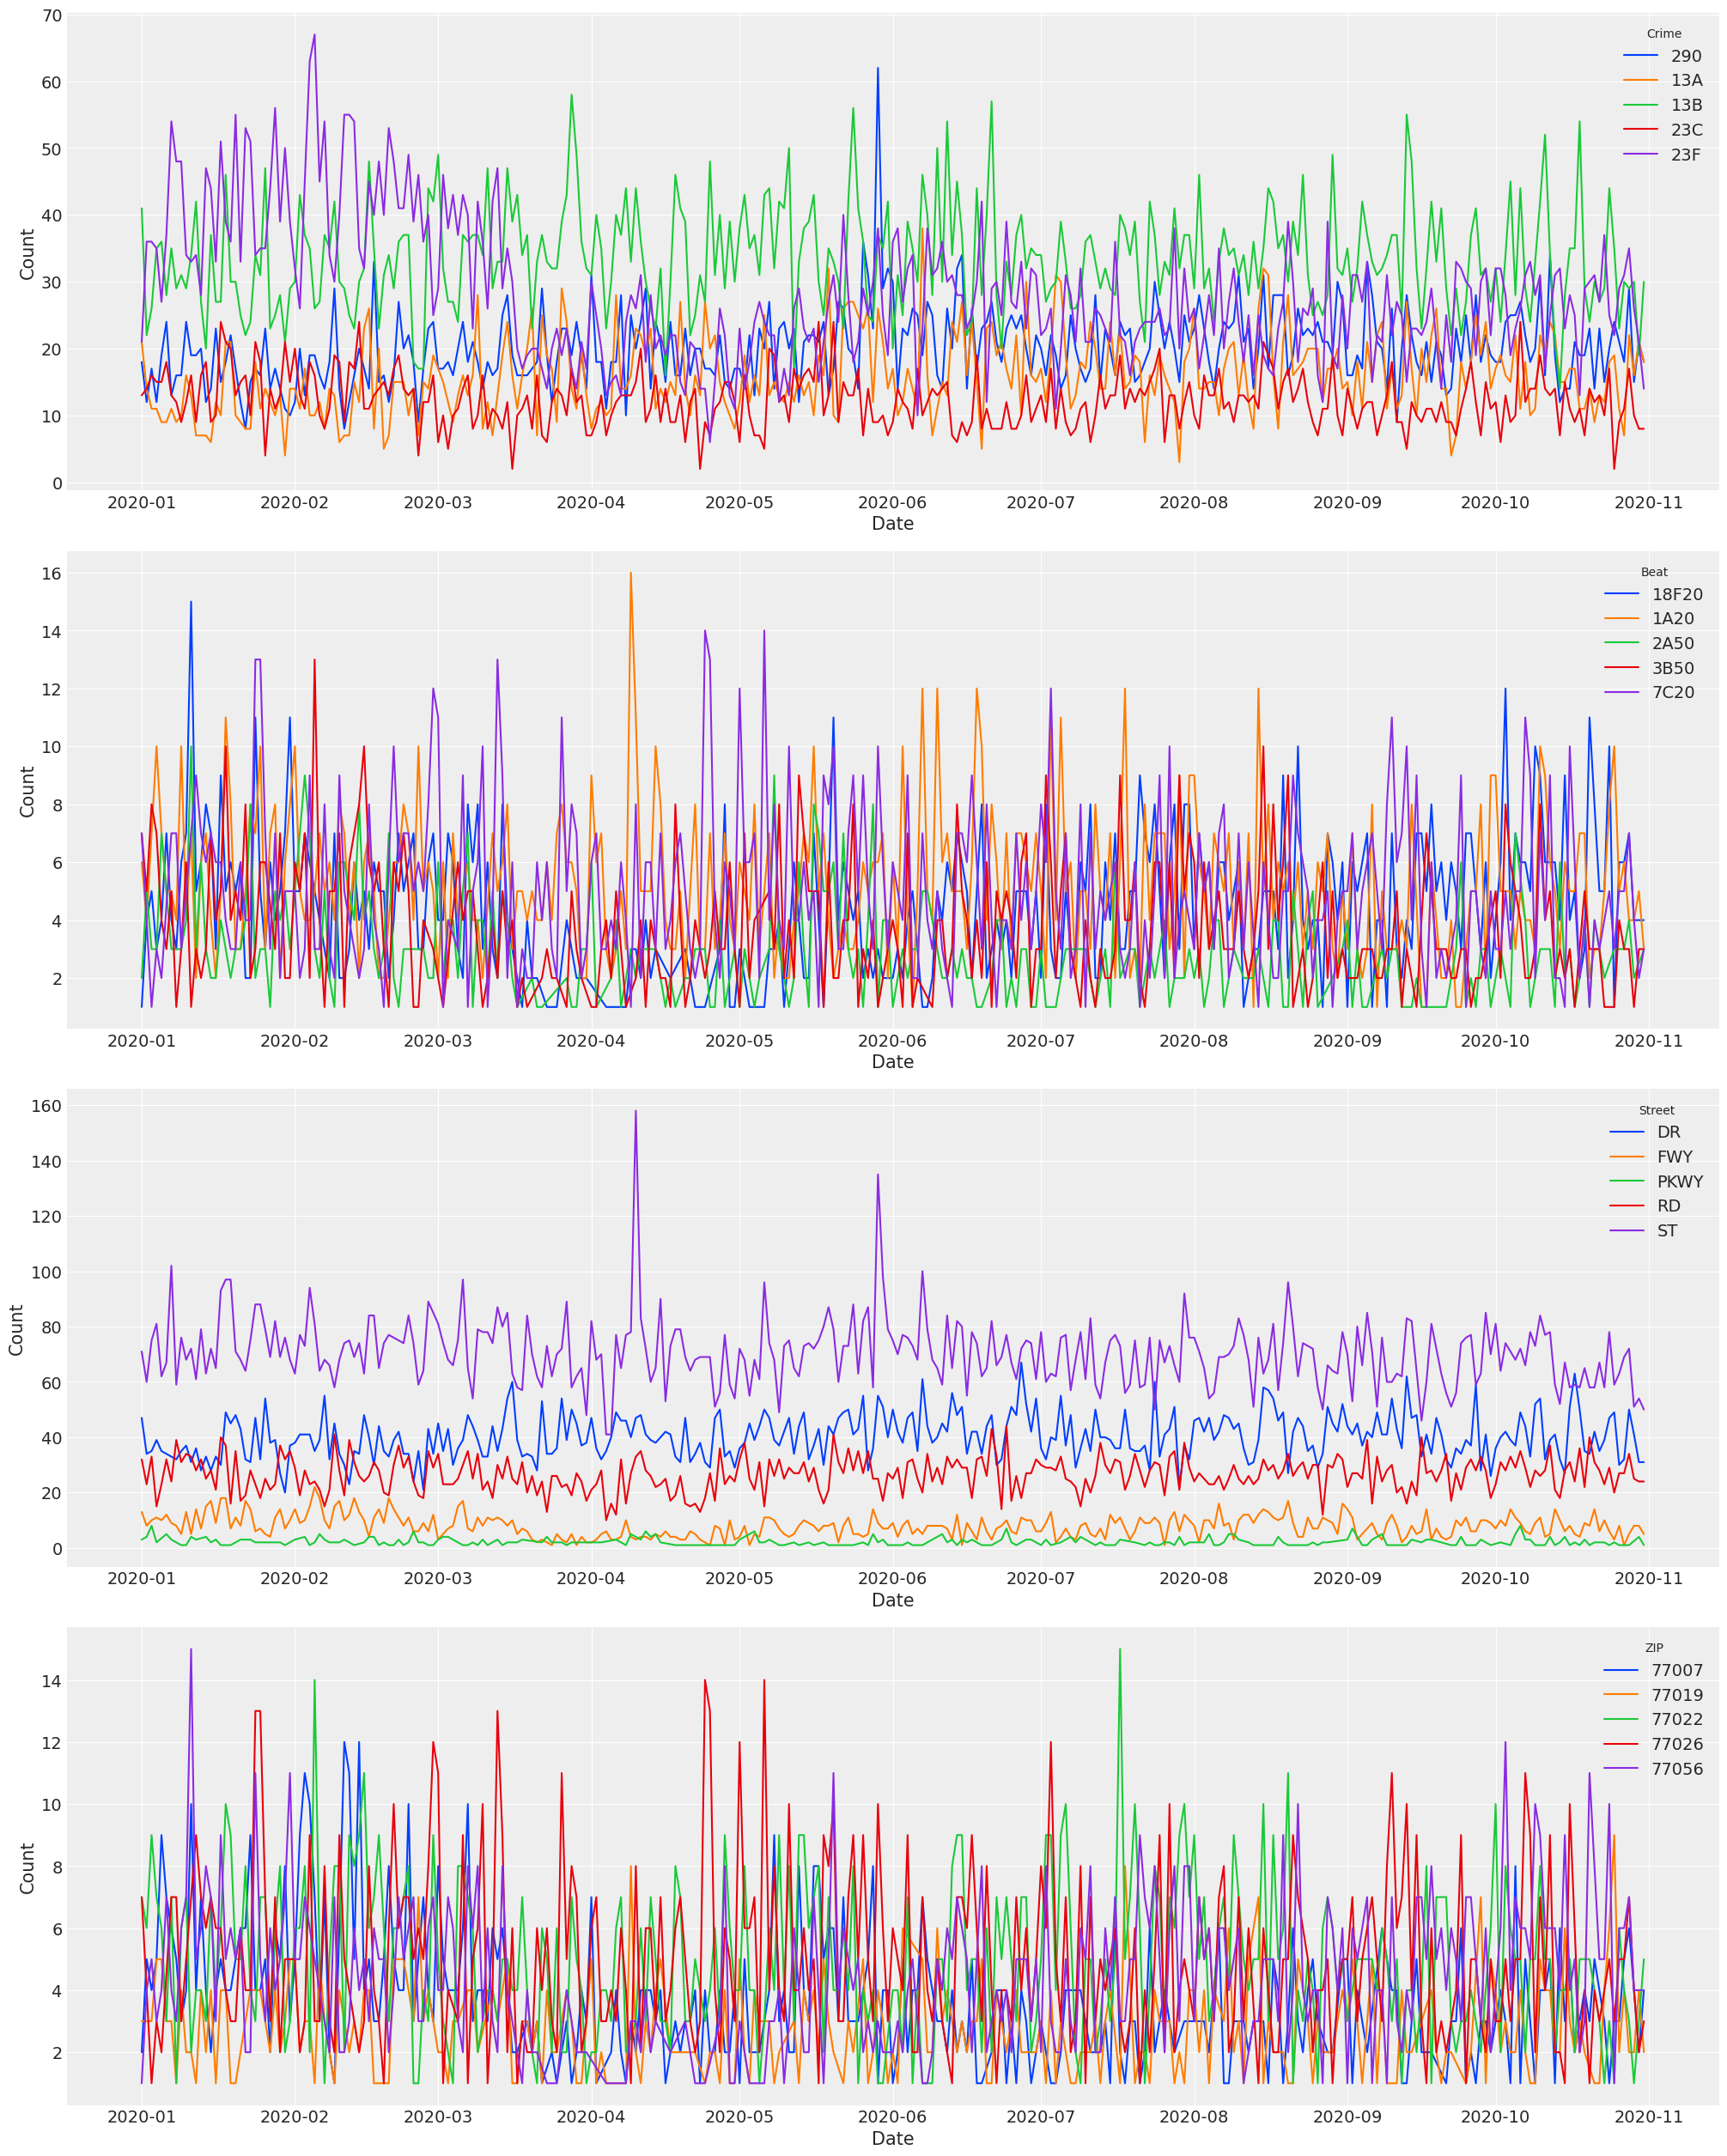

In [52]:
_, ax = plt.subplots(4, 1,figsize=(20,25))
sns.lineplot(ax = ax[0],
             data=police.loc[police['Crime'].isin(police['Crime'].unique()[:5])].groupby(['Date','Crime']).sum(), 
             x="Date", y="Count", hue="Crime");
sns.lineplot(ax = ax[1],
             data=police.loc[police['Beat'].isin(police['Beat'].unique()[:5])].groupby(['Date','Beat']).sum(), 
             x="Date", y="Count", hue="Beat");
sns.lineplot(ax = ax[2],
             data=police.loc[police['Street'].isin(police['Street'].unique()[:5])].groupby(['Date','Street']).sum(), 
             x="Date", y="Count", hue="Street");
sns.lineplot(ax = ax[3],
             data=police.loc[police['ZIP'].isin(police['ZIP'].unique()[:5])].groupby(['Date','ZIP']).sum(), 
             x="Date", y="Count", hue="ZIP");

In [53]:
police_pivot = police.reset_index().pivot(index='Date',columns=['Crime', 'Beat', 'Street', 'ZIP'], values='Count')
police_pivot = police_pivot.fillna(0)

In [54]:
groups_input = {
    'Crime': [0],
    'Beat': [1],
    'Street': [2],
    'ZIP': [3]
}

In [55]:
groups = generate_groups_data(police_pivot, groups_input, seasonality=7, h=30)

Number of groups: 4
	Crime: 15
	Beat: 79
	Street: 9
	ZIP: 68
Total number of series: 500
Number of points per series for train: 275
Total number of points: 305
Seasonality: 7
Forecast horizon: 30


In [6]:
m = HGPforecaster(groups_data=groups, regularize_lengthscale=True)
m.fit()

Fitting model...



Sampling...


In [7]:
m.predict()

Sampling...


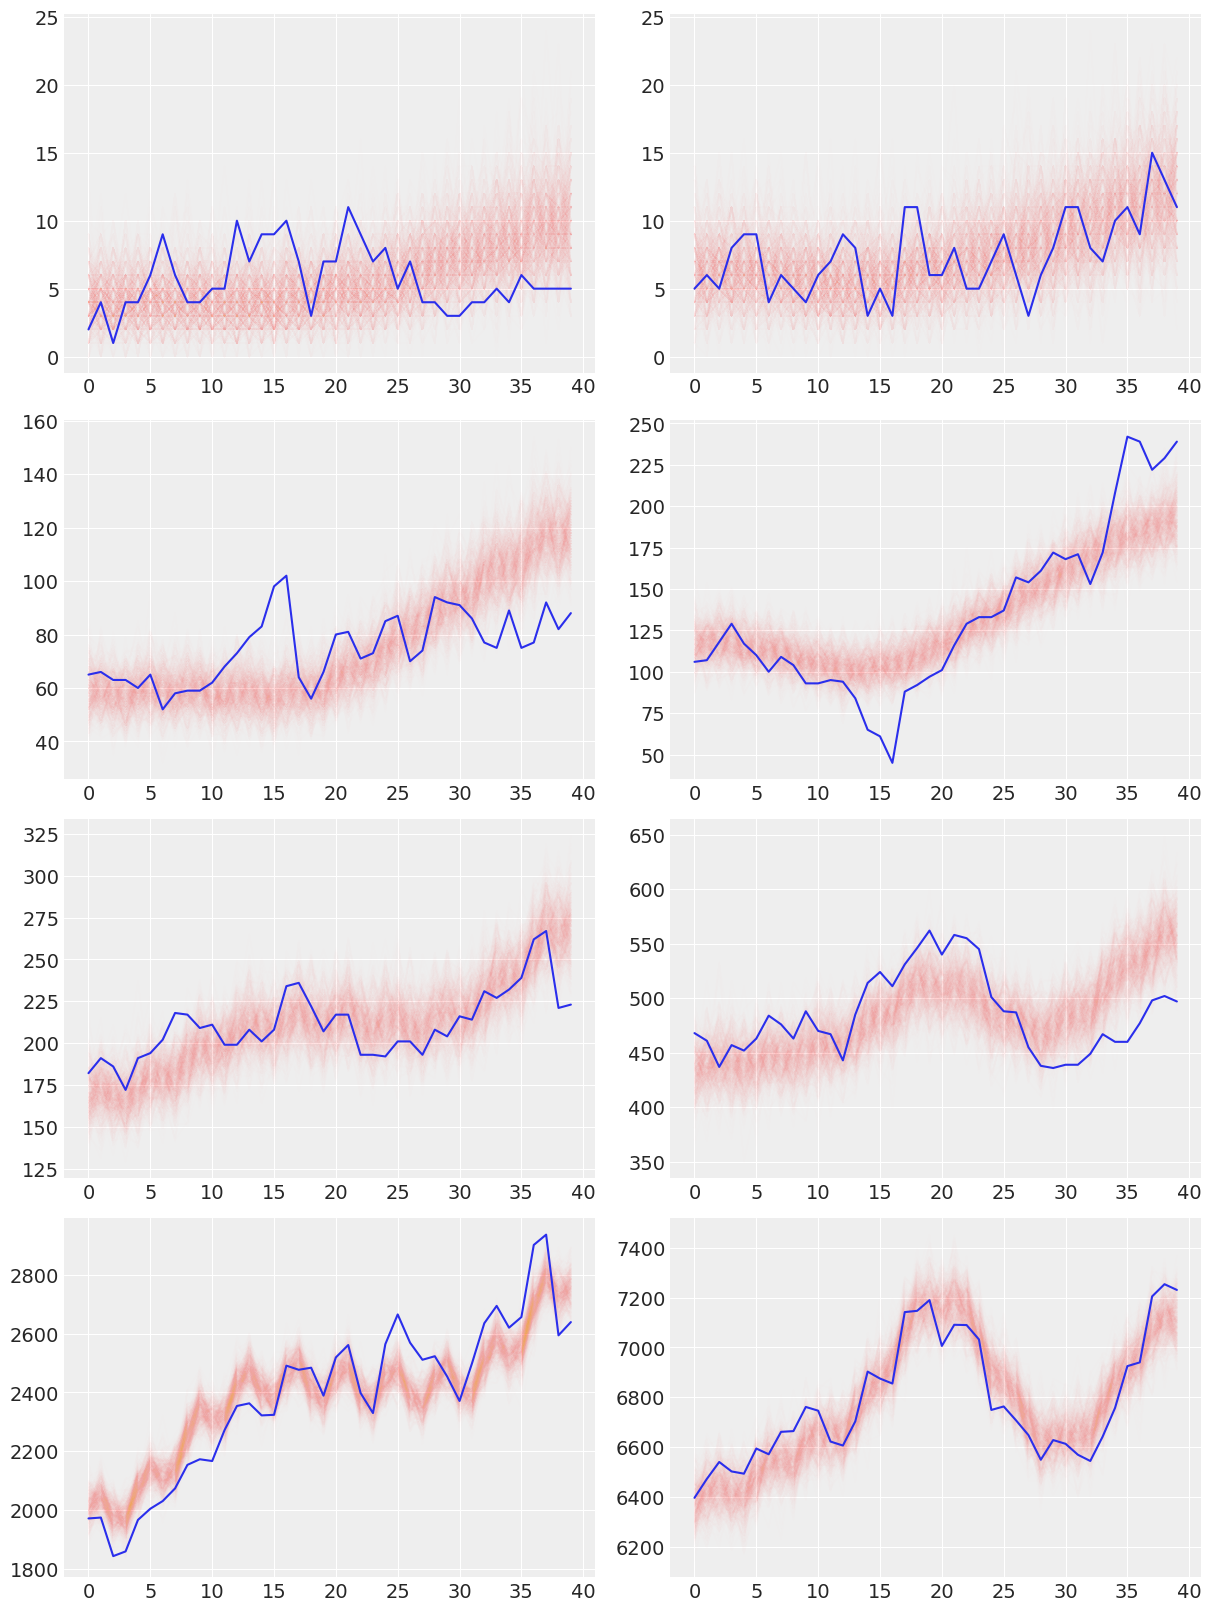

In [8]:
visualize_fit(groups, m.pred_samples_fit, 8)

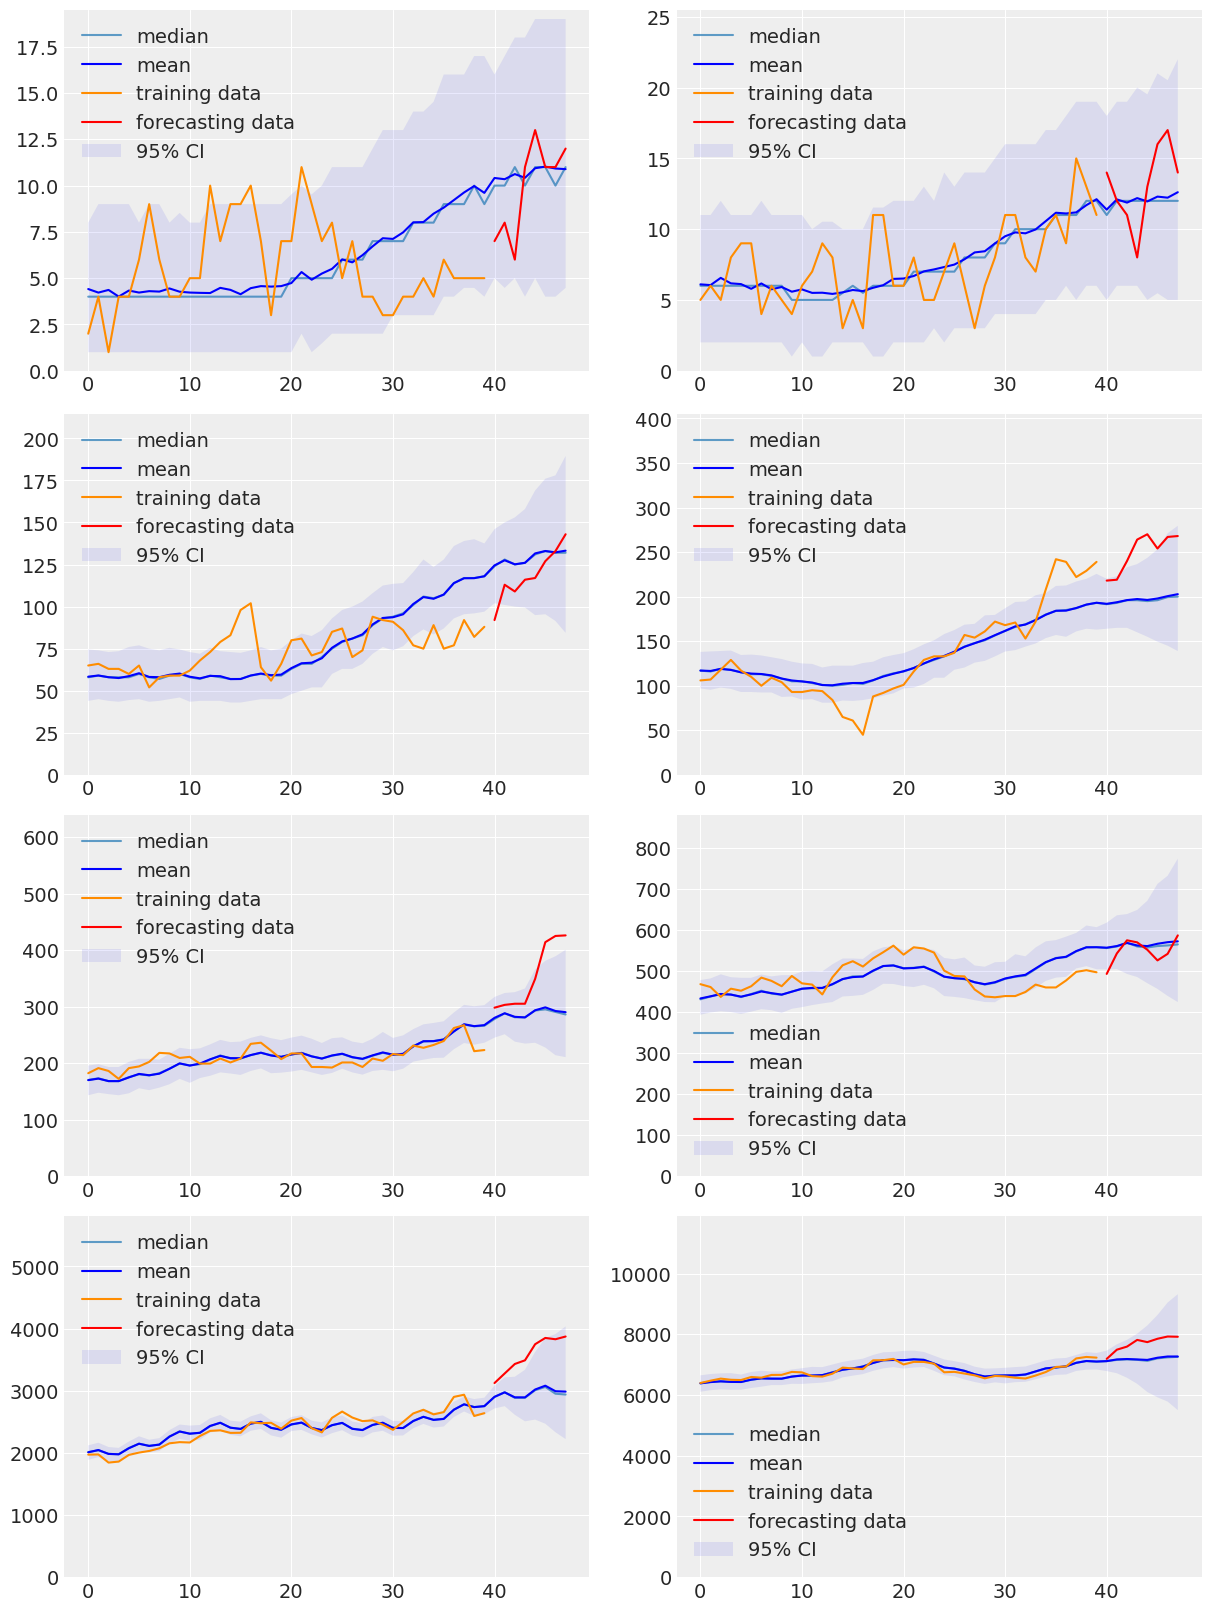

In [12]:
visualize_predict(groups, m.pred_samples_predict, 8)

In [10]:
results = calculate_metrics(m.pred_samples_predict, groups)

In [11]:
metrics_to_table(groups, results)

,bottom,total,state,gender,legal,all
mase,2.206,0.319,1.829,0.318,2.512,1.996
rmse,136.04,422.004,376.364,215.971,1384.785,167.814
